# Training on real spectra
Real data for testing: NOAA (CSAC) observations collected on 26 September 2014

In [1]:
import sys, os, glob
sys.path.append('..')
import numpy as np
import torch
from astropy.io import fits
import numpy.ma as ma
from inverse_problem.nn_inversion.posthoc import open_param_file
from inverse_problem.nn_inversion.transforms import inverse_transformation
from inverse_problem.nn_inversion.posthoc import read_spectrum_for_refer
from inverse_problem.nn_inversion import normalize_spectrum

In [4]:
def params_masked_rows(pars_arr):
    max_par_values = np.array([par_arr.max() for par_arr in pars_arr.T])
    min_par_values = np.array([par_arr.min() for par_arr in pars_arr.T])
    bool_arr = (min_par_values + 1e-3 < pars_arr) & (pars_arr < max_par_values - 1e-3)
    return np.all(bool_arr, axis=1)

def create_masked_array(pars_arr):
    rows_mask = params_masked_rows(pars_arr)
    array_mask = rows_mask[:, np.newaxis] | np.zeros_like(pars_arr, dtype=bool)
    return ma.masked_array(pars_arr, mask=~array_mask)

In [5]:
from inverse_problem.nn_inversion.model_pi_mlp_conv import PIMLPConvNet
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
names = ['Field Strength',
         'Field Inclination',
         'Field Azimuth',
         'Doppler Width',
         'Damping',
         'Line Strength',
         'Source Function (SF)',
         'Cont. SF Gradient',
         'Doppler Shift (DS)',
         'Filling Factor',
         'Stray Light DS']

In [8]:
save_path = '../unc_pred_with_conv_04-01_00-41/'
n_epochs = 4
model = PIMLPConvNet(top_output=22)
model.load_state_dict(torch.load(save_path + '_ep' + str(n_epochs - 1) + '.pt', map_location=device)['model_state_dict'])
model.to(device);

In [9]:
def open_spectrum_data(sp_folder, date, idx):
    sp_path = os.path.join(sp_folder,date[0],date[1],date[2],'SP3D')
    sp_path = glob.glob(f'{sp_path}/*/')[0]
    sp_lines =  sorted(glob.glob(sp_path+'*.fits'))
    return fits.open(sp_lines[idx])


def real_spectra(spectra_file):
    real_I = spectra_file[0].data[0][:,56:].astype('float64')*2
    real_Q = spectra_file[0].data[1][:,56:].astype('float64')
    real_U = spectra_file[0].data[2][:,56:].astype('float64')
    real_V = spectra_file[0].data[3][:,56:].astype('float64')
    return np.concatenate((real_I, real_Q, real_U, real_V), axis = 1)


def prepare_real_mlp(sp_folder, date, factors = None, cont_scale = None, device = None):
    real_samples, cont = read_spectrum_for_refer(sp_folder, date)
    norm_real_samples = normalize_spectrum(np.reshape(real_samples, (-1,56,4), order='F'), factors = factors)
    norm_cont = cont/cont_scale
    norm_real_samples = np.reshape(norm_real_samples, (-1,224), order='F')
    real_x = [torch.from_numpy(norm_real_samples).float().to(device), torch.from_numpy(norm_cont).float().to(device)]
    return real_x


def prepare_real_conv(sp_folder, date, factors=None, cont_scale=None, device=None):
    real_samples, cont = read_spectrum_for_refer(sp_folder, date)
    norm_real_samples = normalize_spectrum(np.reshape(real_samples, (-1, 56, 4), order='F'),
                                           factors=factors)
    norm_cont = cont / cont_scale
    norm_real_samples = np.swapaxes(norm_real_samples, 1, 2)
    real_x = [torch.from_numpy(norm_real_samples).float().to(device), torch.from_numpy(norm_cont).float().to(device)]
    return real_x

In [10]:
factors, cont_scale = [1, 1000, 1000, 1000], 40000
angle_transformation, logB = True, True

In [11]:
path_to_folder = '../data/'
date = ['2014','09','26','17']
sp_folder = os.path.join(path_to_folder, 'sp_20140926_170005')
sp_path = os.path.join(sp_folder,date[0],date[1],date[2],'SP3D')
sp_path = glob.glob(f'{sp_path}/*/')[0]
sp_lines =  sorted(glob.glob(sp_path+'*.fits'))
print(f'Number of files: {len(sp_lines)}')

real_x_test = prepare_real_mlp(sp_folder, date, factors = factors, cont_scale = cont_scale, device = device)
path_to_refer = '../data/sp_20140926_170005/20140926_170005.fits'
data, names = open_param_file(path_to_refer, normalize=True, angle_transformation = angle_transformation, logB = logB, print_params=False)

Number of files: 873


In [15]:
model.eval()
with torch.no_grad():
    predicted = model(real_x_test)

In [16]:
predicted_mean = predicted[:, :11].detach().cpu().numpy()
predicted_sigma = torch.exp(predicted[:, 11:]).detach().cpu().numpy()

In [17]:
mask = create_masked_array(data)
refer2 = mask.data.reshape(-1, 11)

In [18]:
true = inverse_transformation(refer2, inv_logB=False, inv_angle_transformation=False)

In [19]:
from inverse_problem.nn_inversion.transforms import inverse_transformation_unc
predicted_mean_norm, predicted_sigma_norm = inverse_transformation_unc(predicted_mean, predicted_sigma, inv_logB=False, inv_angle_transformation=False)

In [20]:
def normalizeData(d):
    max_elem, min_elem = np.max(d), np.min(d)
    return (d - min_elem)/(max_elem-min_elem)

In [21]:
params_data = predicted_mean_norm.copy()
params_data[:, 5] = normalizeData(params_data[:, 5])
params_data[:, 6] = normalizeData(params_data[:, 6])
params_data[:, 7] = normalizeData(params_data[:, 7])

In [22]:
true_data = true.copy()
true_data[:, 5] = normalizeData(true_data[:, 5])
true_data[:, 6] = normalizeData(true_data[:, 6])
true_data[:, 7] = normalizeData(true_data[:, 7])

In [35]:
save_path

'../unc_pred_02-08_19-02/'

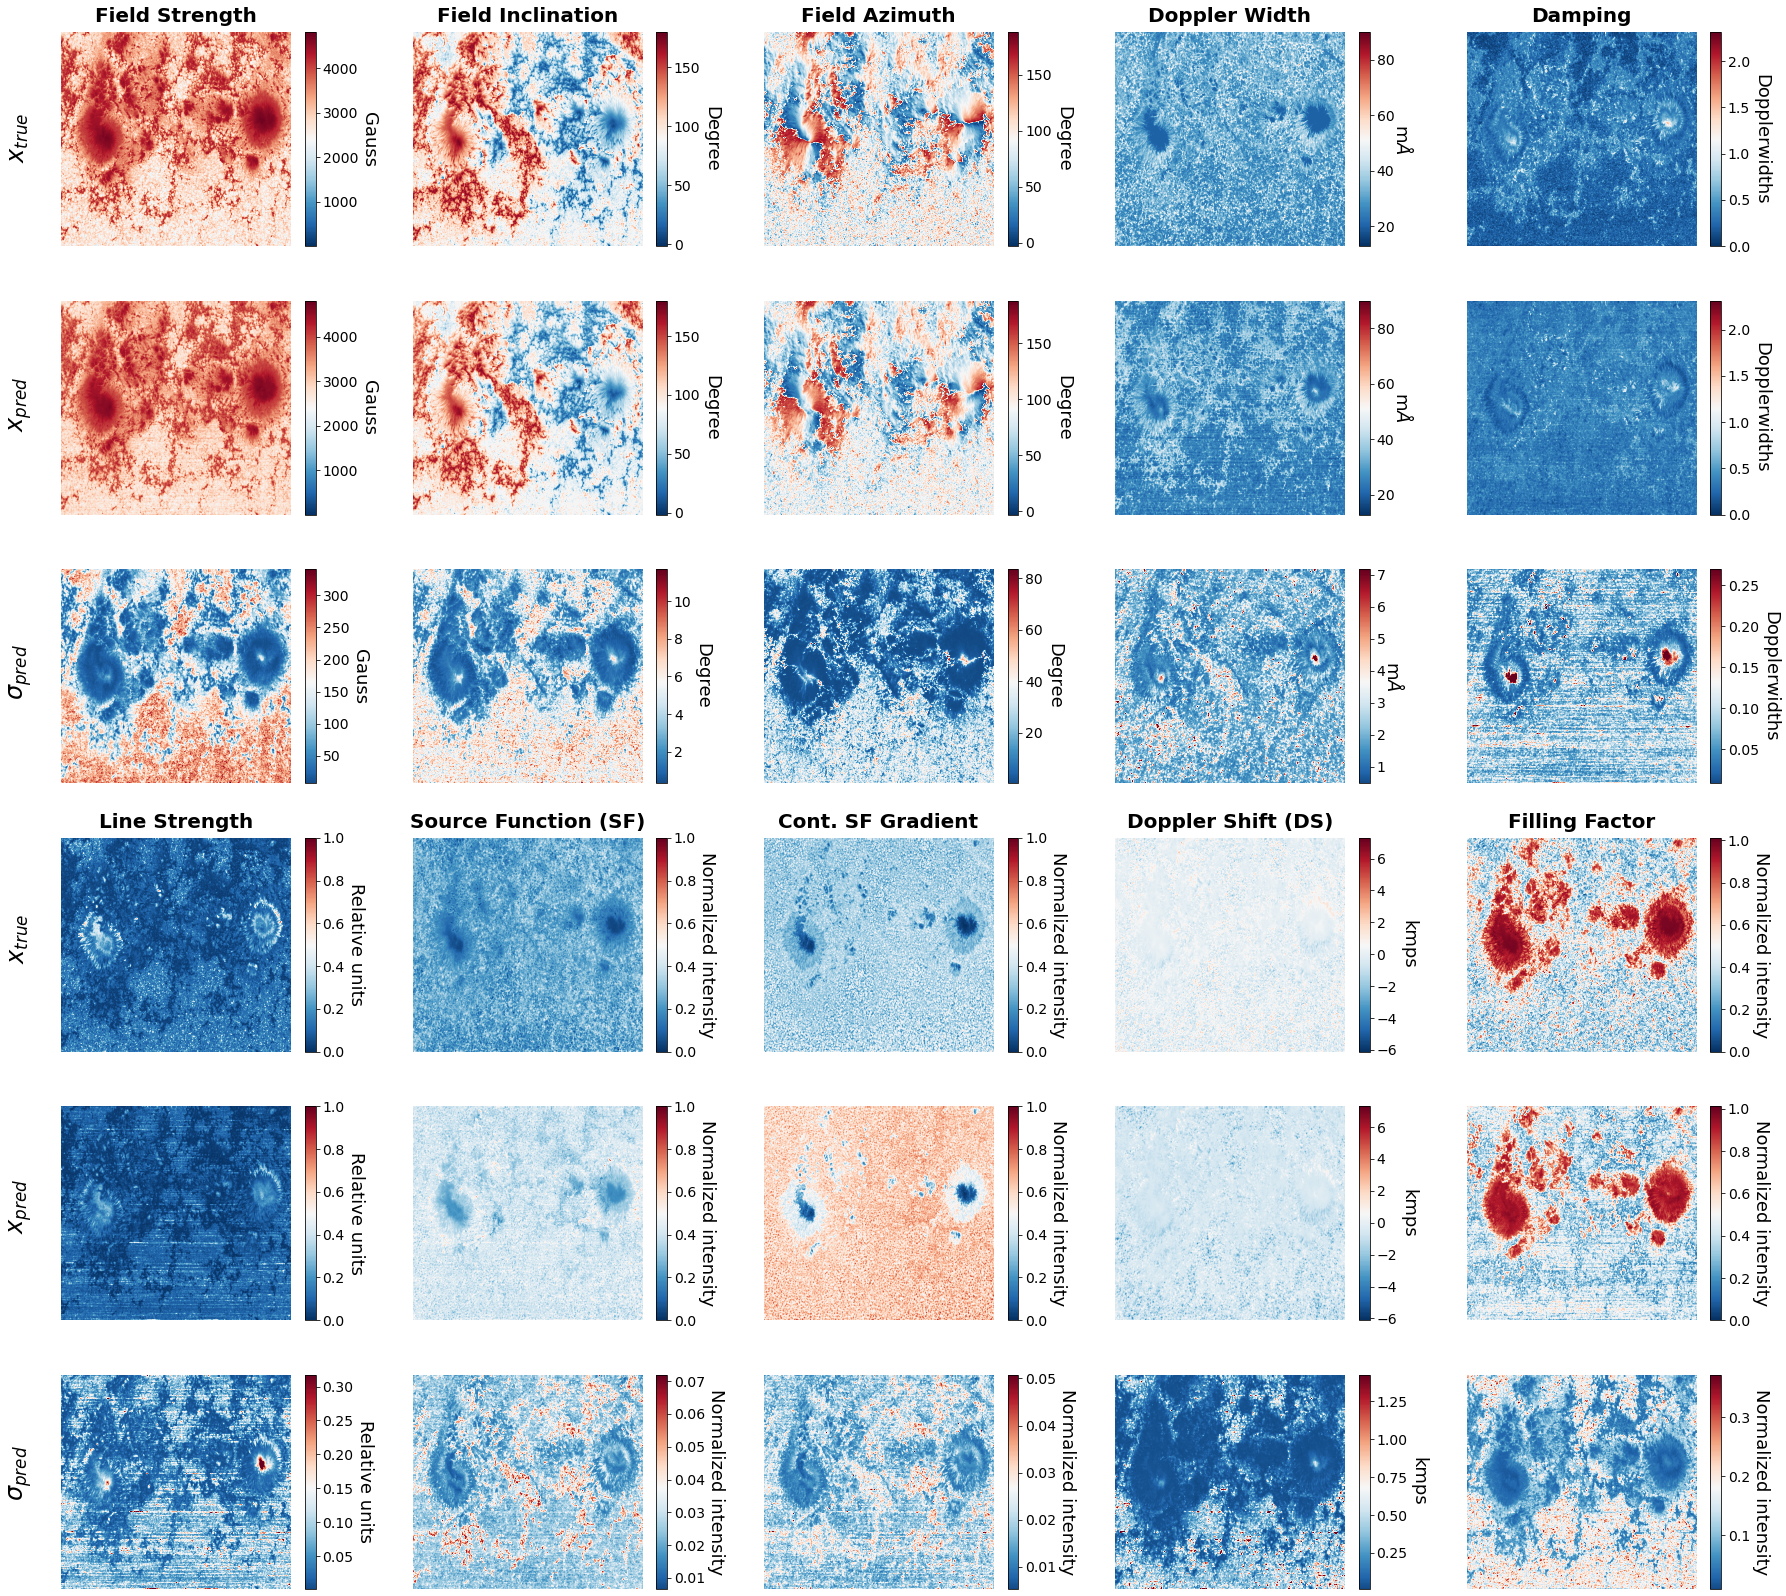

In [53]:
from inverse_problem.nn_inversion.posthoc import plot_params3
plot_params3(true_data.reshape(data.shape), params_data.reshape(data.shape), predicted_sigma_norm.reshape(data.shape), names, save_path=save_path, title='RB', color_map='RdBu', inverse=True)